# NNML
### Nerual Network Language Model，神经网络语言模型


与传统的估计算法$p(w_t|w_{t-(n-1)},...w_{t-1})$不同，NNLM模型直接通过一个神经网络结构对n元条件概率进行评估，NNLM 模型的基本结构如下：
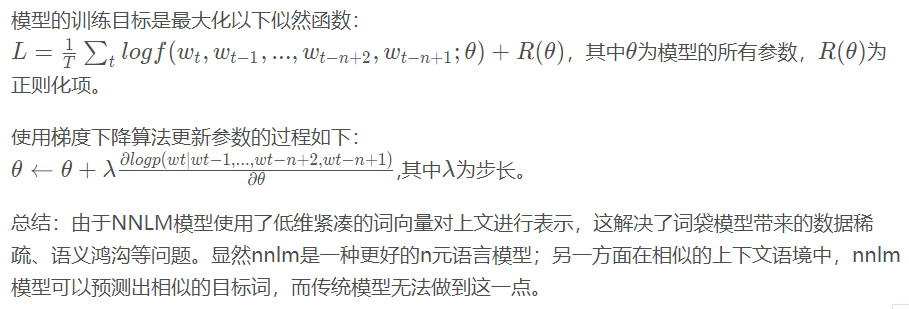

## 模型原理
1. 模型输入 语料：长度为n的文本序列，文本是one-hot encodding
2. 模型层数： 2个隐层，一个是共享的词特征层C，一个是原始的tanh 隐层。传到输出层 经过softmax 概率归一化输出。

$y = b + Wx + Utanh(d+Hx)$
其中 $y_i$是每个词i的概率归一化之前的值。


NNLM的目标是训练如下模型，$f(w_t, w_{t-1},...w_{t-n+1}) = p(w_t|w_{1,t-1})$ ，其中$W_t$ 是词序列中的第t个单词，$w_{1,t-1}$是表示从第一个词到第t个词组成的子序列，模型需要满足的约束条件是:
 $f(w_t,w_{t-1},...w_{t-n+1}) > 0$
 $\sum_{i, |V|} f(w_t, w_{t-1},... w_{t-n+2},w_{t-n+1}) = 1$

上面的模型是当给定一段序列时，由其前面的 t-1个词预测第t个词的概率。
限制条件一：通过网络得到的每个概率值都要大于0
限制条件二：因为神经网络模型最终得到的输出是针对每t-1个词的输入来预测下一个词的输出，因此模型实际输出是一个向量，且该向量的每一个分量依次对应下一个词为词典中某个词的概率。所以|V|维的概率值中必定有一个最大的概率，而其他概率较小且所有概率和为1。

### 前向传播过程：
该模型可分为特征映射和计算条件概率分布两部分。
- 特征映射： 通过映射矩阵C (|V|*m)将输入的每个词映射为一个特征向量，C(i)表示词典中第i个词对应的特征向量，其中m表示特征向量的维度，这里的映射可以是one-hot。然后通过特征映射搭到$C(w_{t-n+1})$...$C(w_{t-1})$ 合并成一个 (n-1)*m维的向量。因为每一个词时m维，总共有n-1个词，所以总共有（n-1）*m维度。 即一个从词汇表V到实数向量空间的映射C。 通过映射得到每个单词的向量表示。
- 计算条件概率分布：通过函数g(前馈或递归神经网络)将输入的词向量序列(C($w-{t-n+1}...C($W_{t-1}$)$))转化为一个概率分布y，所以这里的输出是|V|维，和词典的维度相同，y中第i位表示词序列中第n个词是$v_i$的概率。即 $f(i, w_{t-1}, ...w_{t-n+2},w_{t-n+1}) = g(i,C(W_{t-n+1),...C(W_{t-1}))$
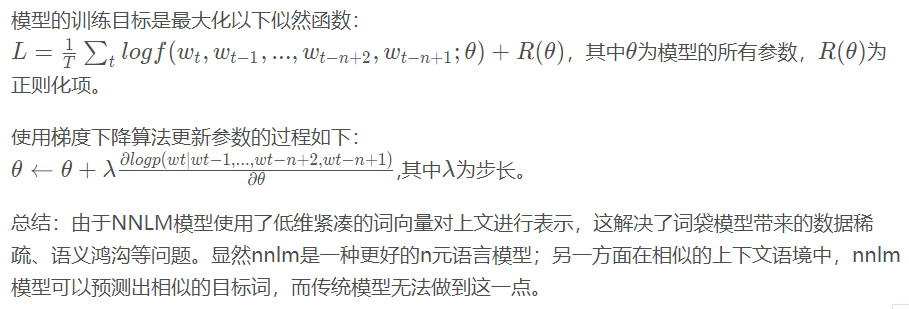

### 模型训练
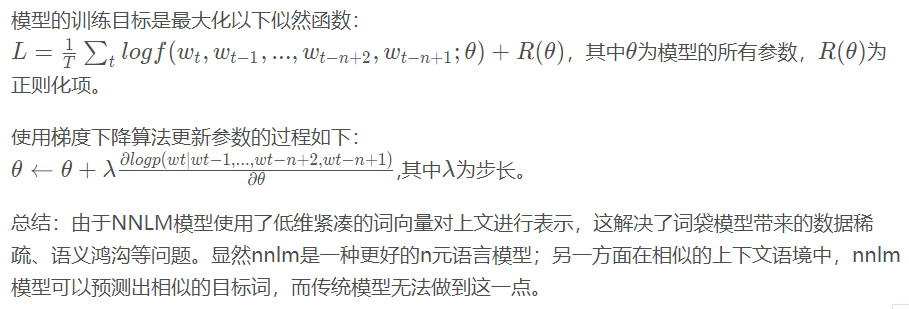

可参考：
1. https://blog.csdn.net/lilong117194/article/details/82018008
2. https://www.zhihu.com/question/32275069

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable

dtype = torch.FloatTensor
sentences = ['i like dog', 'i love coffee', 'i hate milk']

word_list = " ".join(sentences).split()
word_list = list(set(word_list))
word_dict = {w: i for i, w in enumerate(word_list)}
number_dict = {i : w for i, w in enumerate(word_list)}

n_class = len(word_dict)

##NNLM parameter
n_step = 2 # n-1 in paper
n_hidden = 2
m = 2
def make_batch(sentences):
    input_batch = []
    target_batch = []
    for sen in sentences:
        word = sen.split()
        input = [word_dict[n] for n in word[:-1]]
        target = word_dict[word[-1]]
        
        input_batch.append(input)
        target_batch.append(target)
    return input_batch, target_batch


In [2]:
torch.mm ?#Performs a matrix multiplication of the matrices :attr:`input` and :attr:`mat2`.

In [6]:
class NNLM(nn.Module):
    def __init__(self):
        super(NNLM, self).__init__()
        self.C = nn.Embedding(n_class, m)
        self.H = nn.Parameter(torch.randn(n_step * m, n_hidden).type(dtype))
        self.W = nn.Parameter(torch.randn(n_step * m, n_class).type(dtype))
        self.d = nn.Parameter(torch.randn(n_hidden).type(dtype))
        self.U = nn.Parameter(torch.randn(n_hidden, n_class).type(dtype))
        self.b = nn.Parameter(torch.randn(n_class).type(dtype))
    def forward(self, x): 
        #y = b + Wx + Utanh(d+Hx)
        x = self.C(x)
        x = x.view(-1, n_step * m) ##[batch_size, n_step * n_class]
        tanh = torch.tanh(self.d + torch.mm(x, self.H))
        output = self.b + torch.mm(x, self.W) + torch.mm(tanh, self.U)
        return output



In [7]:
model = NNLM()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)
input_batch, target_batch = make_batch(sentences)
input_batch = Variable(torch.LongTensor(input_batch))
target_batch = Variable(torch.LongTensor(target_batch))

## trainning 
for epoch in range(5000):
    optimizer.zero_grad()
    output = model(input_batch)
    ## output:[batch_size, n_class], target_batch:[batch_size](LongTensor,not onehot )
    loss = criterion(output, target_batch)
    if (epoch + 1) % 1000 == 0:
        print('epoch: %04d' % (epoch + 1), 'cost = {:.6f}'.format(loss))
    loss.backward()
    optimizer.step()

## predict
predict = model(input_batch).data.max(1, keepdim = True)[1]

## test
print([sen.split()[:2] for sen in sentences], '->', [number_dict[n.item()] for n in predict.squeeze()])

epoch: 1000 cost = 0.091075
epoch: 2000 cost = 0.017985
epoch: 3000 cost = 0.006735
epoch: 4000 cost = 0.003116
epoch: 5000 cost = 0.001589
[['i', 'like'], ['i', 'love'], ['i', 'hate']] -> ['dog', 'coffee', 'milk']
